In [4]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
!pip install imutils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# For Linux
# DIRECTORY = r"/home/apple/Desktop/Face_Mask_Project/dataset/"

DIRECTORY = r"F:/Spring 22-23/CVPR/CVPR/dataset/"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# convert text to Binary
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# Create head and the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Call head and the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them
for layer in baseModel.layers:
	layer.trainable = False

# compile our model 17
print("Compilation of the MODEL is going on...")
opt = legacy.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("Training Head Started...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("Network evaluation...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("saving mask model...")
model.save("mask_detector.model", save_format="h5")

C:\Users\herep\anaconda3\envs\CVPR\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Compilation of the MODEL is going on...


C:\Users\herep\anaconda3\envs\CVPR\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training Head Started...
Epoch 1/20
95/95 [==============================] - 113s 1s/step - loss: 0.3892 - accuracy: 0.8504 - val_loss: 0.1208 - val_accuracy: 0.9909
Epoch 2/20
95/95 [==============================] - 104s 1s/step - loss: 0.1364 - accuracy: 0.9677 - val_loss: 0.0670 - val_accuracy: 0.9896
Epoch 3/20
95/95 [==============================] - 100s 1s/step - loss: 0.1028 - accuracy: 0.9690 - val_loss: 0.0481 - val_accuracy: 0.9935
Epoch 4/20
95/95 [==============================] - 104s 1s/step - loss: 0.0780 - accuracy: 0.9740 - val_loss: 0.0408 - val_accuracy: 0.9935
Epoch 5/20
95/95 [==============================] - 103s 1s/step - loss: 0.0570 - accuracy: 0.9822 - val_loss: 0.0380 - val_accuracy: 0.9896
Epoch 6/20
95/95 [==============================] - 105s 1s/step - loss: 0.0591 - accuracy: 0.9829 - val_loss: 0.0317 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 120s 1s/step - loss: 0.0524 - accuracy: 0.9845 - val_loss: 0.0306 - val_accur

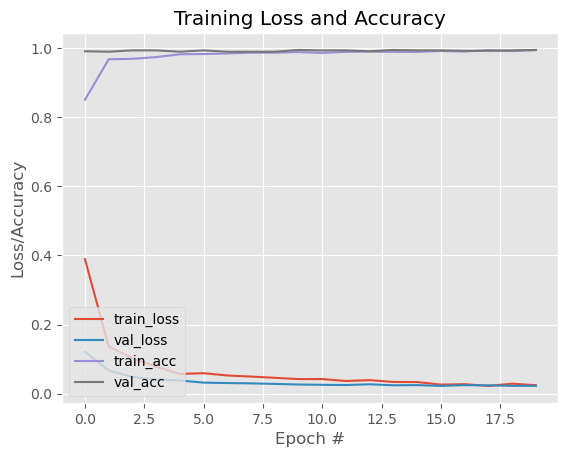

In [5]:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")